# Demos


## Manifold analysis example

Example of manifold analysis in Figure 5d,e and
Supplementary figure 5e-h.

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Here we load the PC linear model data (Supplementary figure 3c,d)
mf_data = pd.read_excel('../data/SupplementaryFigure3.xlsx',
                       sheet_name='Figure S3b,c,d,f',
                       usecols='A:HY',
                       skiprows=2,
                       nrows=502)

pc_data = pd.read_excel('../data/SupplementaryFigure3.xlsx',
                       sheet_name='Figure S3b,c,d,f',
                       usecols='HZ:TP',
                       skiprows=2,
                       nrows=502)



In [3]:
import cbmanifold
from cbmanifold.linear_model import LinearModel

def source_data_to_LinearModel(data, label):
    _, n = data.shape
    n = (n - 1) // 2

    scale = 1e3  # kHz -> Hz

    rate = data.iloc[:, 0:n].values.T * scale
    drate = data.iloc[:, n : 2 * n].values.T * scale
    v0 = data.iloc[:, 2 * n].unique()[0]
    n_params = 1
    lm = LinearModel()
    lm.rate = rate
    lm.drate = drate
    lm.dim = n
    lm.n_params = n_params
    lm.z0 = [v0]
    lm.label = label
    lm.is_dim_reduced = False

    return lm


lm_mf = source_data_to_LinearModel(mf_data, "mossy fiber")
lm_pc = source_data_to_LinearModel(pc_data, "Purkinje cell")

figsize: [6. 5.]


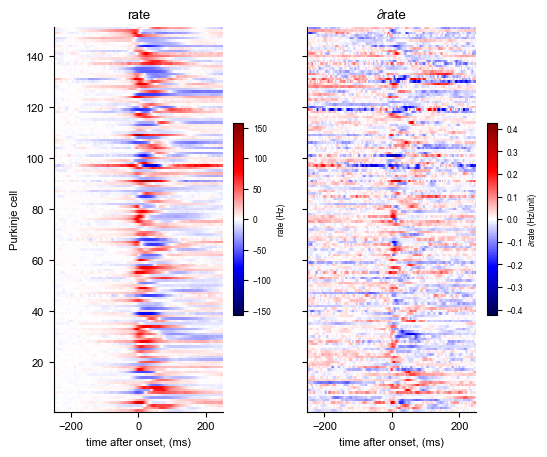

In [4]:
_, _ = cbmanifold.plot.plot_linear_model(lm_pc)

Dimensions: 1, Variance explained: 51.04384881006197
Dimensions: 2, Variance explained: 76.07985014983356
Dimensions: 3, Variance explained: 85.97231371969616
Dimensions: 4, Variance explained: 92.25990202100004
Dimensions: 5, Variance explained: 94.64670779103892
Dimensions to be reduced: 4


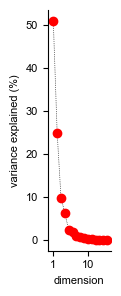

In [5]:
from cbmanifold.decomposition import pmPCA

dd, p, v = pmPCA(lm_pc.rate)
var_explained = dd/np.sum(dd)*1e2;
var_explained_cumsum = np.cumsum(var_explained);
for i in range(5):
    print(f'Dimensions: {i+1}, Variance explained: {var_explained_cumsum[i]}')

nmode = np.where(var_explained_cumsum > 87.5)[0][0]+1
print(f'Dimensions to be reduced: {nmode}')

_ = cbmanifold.plot.plot_var_explained(var_explained)


In [6]:
lmr = cbmanifold.decomposition.reduce_dimensionality(lm_pc, 2)
lmr = cbmanifold.utils.flip_sign(lmr, [1]) # flip signs to make the cycles go CCW

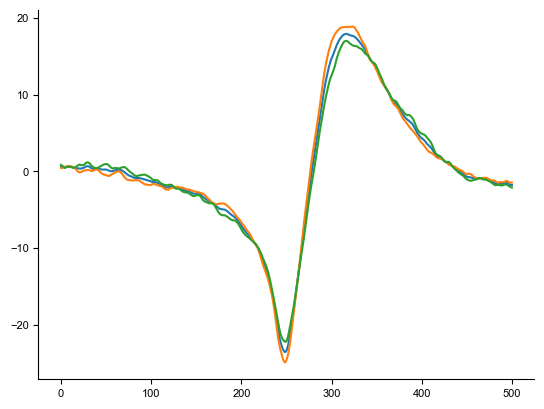

In [7]:
i = 1
plt.plot(0*lmr.dp[i,:]+lmr.p[i,:])
plt.plot(70*lmr.dp[i,:]+lmr.p[i,:])
plt.plot(-70*lmr.dp[i,:]+lmr.p[i,:])


(-30.0, 30.0)

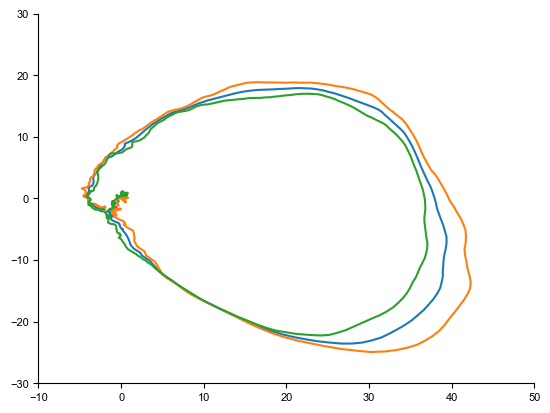

In [8]:
i1, i2 = 0, 1
plt.plot(0*lmr.dp[i1,:]+lmr.p[i1,:], 0*lmr.dp[i2,:]+lmr.p[i2,:])
plt.plot(70*lmr.dp[i1,:]+lmr.p[i1,:], 70*lmr.dp[i2,:]+lmr.p[i2,:])
plt.plot(-70*lmr.dp[i1,:]+lmr.p[i1,:], -70*lmr.dp[i2,:]+lmr.p[i2,:])
plt.xlim([-10, 50])
plt.ylim([-30, 30])


## Linear model construction

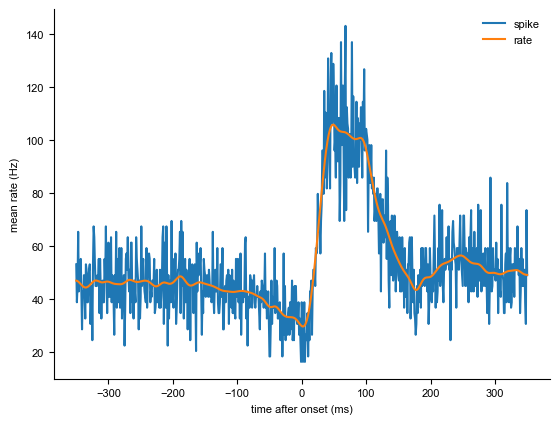

In [97]:
import scipy.io as io

pc3_data = io.loadmat('../data/PC3.mat')

#time
t = pc3_data['t'].ravel()

# spikes
ss = pc3_data['ss']*1e3

# peak velocity
pv = pc3_data['v'].ravel()

# duration
dur = pc3_data['dur'].ravel()
av = 15./dur*1e3 # average velocity

# rate, gaussian filtered with sigma=7
rate = cbmanifold.utils.filter_matrix(ss.T, sigma=7).T

_, ax = plt.subplots()
ax.plot(t, ss.mean(axis=0), label='spike')
ax.plot(t, rate.mean(axis=0), label='rate')
ax.set(xlabel='time after onset (ms)', ylabel='mean rate (Hz)')
ax.legend()

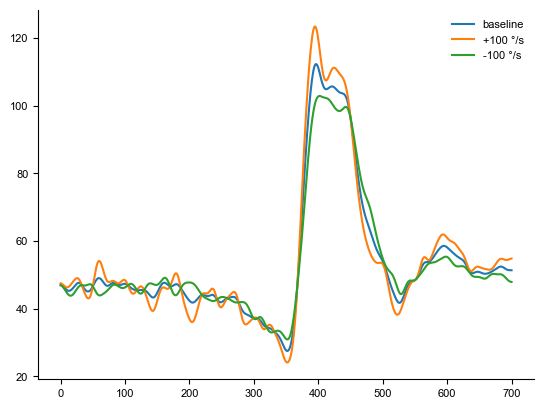

In [ ]:
# grand average of pv and av, from Markanday et al. 2023
pv0 = 591.3913
av0 = 352.6262

# single parameter model
params = np.vstack([pv]).T # should be n_trials x 2
lm = cbmanifold.linear_model.generate_linear_model(rate, params, [pv0], output_type="dict")

plt.plot(lm['rate'], label='baseline')
plt.plot(lm['rate']+lm['drate'][0]*100, label='PV:+100 °/s')
plt.plot(lm['rate']-lm['drate'][0]*100, label='PV:-100 °/s')
plt.legend()


Text(0.5, 1.0, '\n    Peak firing rate is more dependent on AV (=15°/duration) rather than PV. \nThis was not seen in the previous plot since AV and PV were positively correlated.\n')

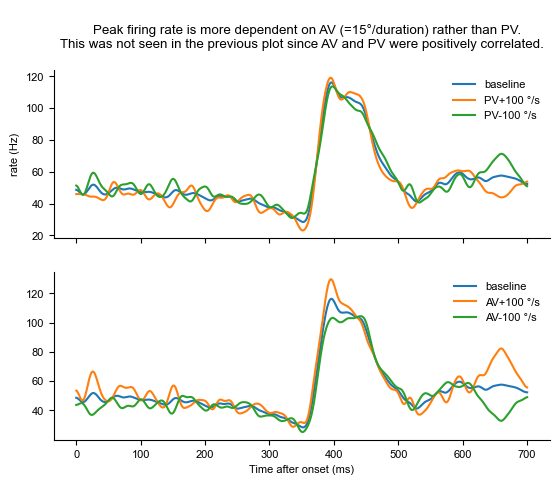

In [123]:
# two parameter model
params = np.vstack([pv, av]).T  # should be n_trials x 2
lm = cbmanifold.linear_model.generate_linear_model(
    rate, params, [pv0, av0], output_type="dict"
)

_, ax = plt.subplots(nrows=2, sharex=True)
ax[0].plot(lm["rate"], label="baseline")
ax[0].plot(lm["rate"] + lm["drate"][0] * 100, label="PV:+100 °/s")
ax[0].plot(lm["rate"] - lm["drate"][0] * 100, label="PV:-100 °/s")
ax[0].legend()
ax[0].set_ylabel("rate (Hz)")

ax[1].plot(lm["rate"], label="baseline")
ax[1].plot(lm["rate"] + lm["drate"][1] * 70, label="AV:+100 °/s")
ax[1].plot(lm["rate"] - lm["drate"][1] * 70, label="AV:-100 °/s")
ax[1].legend()
ax[1].set_xlabel("Time after onset (ms)")

ax[0].set_title(
    """Peak firing rate is more dependent on AV (=15°/duration) rather than PV. \nThis was not seen in the previous plot since AV and PV are positively correlated."""
)

Text(0, 0.5, 'AV (°/s)')

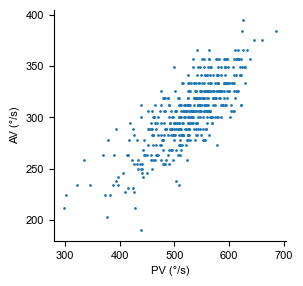

In [129]:
_, ax = plt.subplots(figsize=(3, 3))

ax.scatter(params[:,0], params[:,1], 1)
ax.set_xlabel('PV (°/s)')
ax.set_ylabel('AV (°/s)')
